# Compile datasets

## Prepares LAI and climate data sets for LSTM model

- converts terraclim tifs to an xarray data set
- merges LAI and climate data sets
- masks with the Hansen forest mask
- 
- 

## Setup

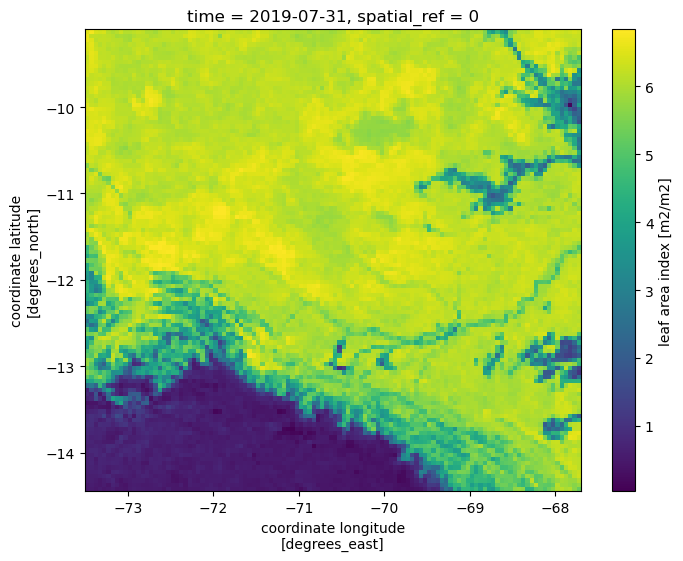

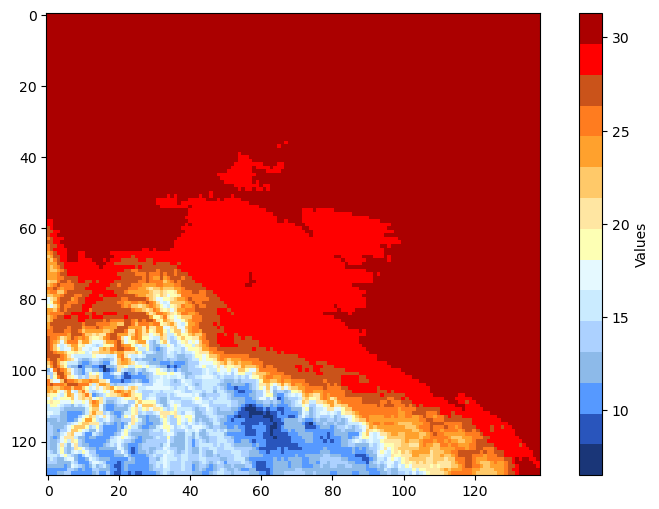

In [4]:
# import packages
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import os
import glob
import rasterio
import re
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from rasterio.enums import Resampling 

# load in data
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# LAI netCDF
# --------------------------

# set path
lai_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/modisLAI/MODIS_LAI_monthly.nc"
# import
lai_xr = xr.open_dataset(lai_path)

# Set spatial dimensions and CRS
lai_xr = lai_xr.rio.set_spatial_dims(x_dim="lon", 
                                     y_dim="lat", 
                                     inplace=False)
lai_xr = lai_xr.rio.write_crs("EPSG:4326", 
                              inplace=True) 

# print some stuff out to check
# print("LAI:", lai_xr) #full data set
# print("CRS:", lai_xr['lai'].rio.crs) #crs
# print("dimensions:", lai_xr['lai'].dims) #dimensions
# print("time steps:", lai_xr.time.values)  # dates

# plot
lai_xr.lai.isel(time=210).plot(figsize=(8,6))

# Climate tifs
# --------------------------

# set path
clim_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/"
# import tif filepaths as a list
clim_tifs = sorted(glob.glob(os.path.join(clim_path, "*.tif")))

#  print some stuff out to check
# climTest_tif = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif")
# print("Clim:", climTest_tif) #full data set
# print("CRS:", climTest_tif.rio.crs) #crs

# plot
# Open raster 
with rasterio.open("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif") as src:
    raster = src.read(1)          # read first band
# Define color palette
palette = [
    '#1a3678', '#2955bc', '#5699ff', '#8dbae9', '#acd1ff', '#caebff', '#e5f9ff',
    '#fdffb4', '#ffe6a2', '#ffc969', '#ffa12d', '#ff7c1f', '#ca531a', '#ff0000',
    '#ab0000'
]
# Visualize
plt.figure(figsize=(10, 6))
plt.imshow(raster, cmap=ListedColormap(palette))
plt.colorbar(label='Values')
plt.show()

In [2]:
# example = glob.glob("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/*.tif")[1]

# with rasterio.open(example) as src:
#     print("CRS:", src.crs)
#     print("Resolution:", src.res)
#     print("Bounds:", src.bounds)

# da = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif")
# print(da.rio.crs)
# print(da)

CRS: GEOGCS["Greenwich",DATUM["unnamed",SPHEROID["unnamed",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Resolution: (0.041666666666666664, 0.041666666666666664)
Bounds: BoundingBox(left=-73.5, bottom=-14.499999999999995, right=-67.70833333333333, top=-9.083333333333329)
GEOGCS["Greenwich",DATUM["unnamed",SPHEROID["unnamed",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
<xarray.DataArray (band: 7, y: 130, x: 139)> Size: 1MB
[126490 values with dtype=float64]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * y            (y) float64 1kB -9.104 -9.146 -9.187 ... -14.4 -14.44 -14.48
  * x            (x) float64 1kB -73.48 -73.44 -73.4 ... -67.81 -67.77 -67.73
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIF

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [18]:
# convert terraclim tifs into an xarray data set

# sort climate tifs into a dictionary
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# create a dictionary of all bands and the xarrays belonging to them for each time step

# create a dictionary to hold each band's xarrays
# Keys = band names (e.g., "band1", "band2")
# Values = list of xarrays (one per time step)
bands_dict = {}  
# create a list to hold time stamps corresponding to each tif
timestamps_list = [] 

# iterate through all the climate tif filepaths
for f in clim_tifs:

    # create time steps
    # --------------------------
    
    # get just the filename
    name_full = os.path.basename(f)
    
    # remove ".tif" and split by "_" to isolate year and month, get a list of 
    # example: "climate_2005_03.tif" -> ["terraClim", "2005", "03"]
    name_parts = name_full.replace(".tif", "").split("_")
    # print(name_parts)

    # convert extracted year and month into integers
    year, month = int(name_parts[1]), int(name_parts[2])
    # print(year, month)

    # create a time stamp that gives it the last day of the month
    # example: 2005, 03 → 2005-03-31
    time_stamp = pd.Timestamp(year=year, month=month, day=1) + pd.offsets.MonthEnd(0)
    # print(time_stamp)

    # store the time stamps for later
    timestamps_list.append(time_stamp)

    # create xarray
    # --------------------------
    
    # load the tif 
    ds = rio.open_rasterio(f, masked=True)
    
    # loop through each band
    for band in range(ds.sizes['band']):

        # create a band name for each band
        band_name = f"band{band+1}"
        # print(band_name)

        # extract the specific band as an xarray dataset
        band_xr = ds.isel(band=band)

        # add a new time dimension, with this band's time stamp
        band_xr = band_xr.expand_dims({'time': [time_stamp]})
        # print(band_xr)
        
        # if the band name is already an item in the bands dictionary, append this time step for that band
        if band_name in bands_dict:
            bands_dict[band_name].append(band_xr)
        # if not, initialize the dictionary item for that band 
        else:
            bands_dict[band_name] = [band_xr]

# print
# print(bands_dict)
# print(timestamps_list)

# combine into one xarray
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# Combine each list of xarrays into one xarray with many data variables

# create a dictionary to hold all the xarrays
# Keys = band names (e.g., "band1", "band2")
# Values = xarrays 
ds_dict = {}

# START HERE!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# loop through the dictionary that contains lists of xarrays per band
for band_name, ds_list in bands_dict.items():

    # For each tif in the list, drop the 'band' coordinate if it exists 
    cleaned_list = [
        ds.drop_vars('band', errors='ignore')   # remove "band" dimension safely
        for ds in ds_list
    ]

    # Concatenate all time slices for this band along the "time" dimension
    # Produces a single (time, y, x) DataArray for each variable
    combined_vars[band_name] = xr.concat(cleaned_list, dim='time')

# Create the final xarray out of all variables
# combined_vars = {"band1": DA(time,lat,lon), "band2": DA(time,lat,lon), ...}
ds_clim = xr.Dataset(combined_vars)

# Rename spatial dims if needed:
# tif files usually import with dims ("x","y"), but climate data is ("lat","lon")
# We rename x→lon and y→lat so everything is consistent
ds_clim = ds_clim.rename({'x': 'lon', 'y': 'lat'})

# Tell rioxarray explicitly which dimensions represent spatial coordinates
ds_clim = ds_clim.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

# Print the final structured Dataset
print(ds_clim)

{'band1': [<xarray.DataArray (time: 1, y: 130, x: 139)> Size: 145kB
array([[[31.2, 31.1, 31. , ..., 30.5, 30.4, 30.5],
        [31.2, 31.1, 31. , ..., 30.5, 30.5, 30.4],
        [31.1, 31.1, 31.1, ..., 30.4, 30.4, 30.4],
        ...,
        [12.2, 12. , 12.4, ..., 30. , 29.8, 29.2],
        [11.1, 10.9, 11.3, ..., 30.1, 30.2, 30. ],
        [10.2, 10.9, 11.4, ..., 30.3, 30.3, 30.2]]], shape=(1, 130, 139))
Coordinates:
  * time         (time) datetime64[ns] 8B 2000-01-31
  * y            (y) float64 1kB -9.104 -9.146 -9.187 ... -14.4 -14.44 -14.48
  * x            (x) float64 1kB -73.48 -73.44 -73.4 ... -67.81 -67.77 -67.73
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0, <xarray.DataArray (time: 1, y: 130, x: 139)> Size: 145kB
array([[[30.8, 30.8, 30.7, ..., 30.1, 

In [6]:
ds_clim_4326 = ds_clim.rio.reproject("EPSG:4326")
ds_clim_4326

<xarray.Dataset> Size: 304MB
Dimensions:      (x: 139, y: 130, time: 300)
Coordinates:
  * x            (x) float64 1kB -73.48 -73.44 -73.4 ... -67.81 -67.77 -67.73
  * y            (y) float64 1kB -9.104 -9.146 -9.187 ... -14.4 -14.44 -14.48
  * time         (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2024-12-31
    spatial_ref  int64 8B 0
Data variables:
    band1        (time, y, x) float64 43MB 31.2 31.1 31.0 ... 31.9 31.9 31.7
    band2        (time, y, x) float64 43MB 21.4 21.3 21.2 ... 22.9 22.8 22.7
    band3        (time, y, x) float64 43MB 134.0 134.0 136.0 ... 170.0 172.0
    band4        (time, y, x) float64 43MB -1.59 -1.6 -1.59 ... -6.87 -6.89
    band5        (time, y, x) float64 43MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    band6        (time, y, x) float64 43MB 0.8 0.79 0.78 0.78 ... 1.08 1.08 1.06
    band7        (time, y, x) float64 43MB 157.7 156.9 156.0 ... 84.5 85.1 84.9

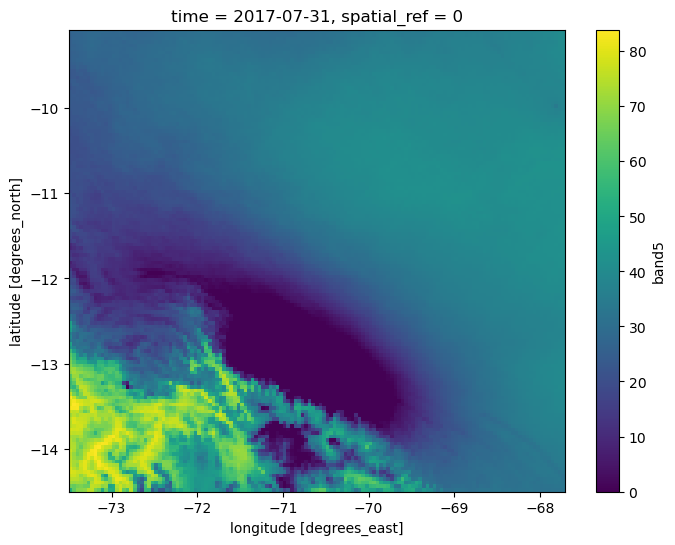

In [7]:
ds_clim_4326.band5.isel(time=210).plot(figsize=(8,6))

In [8]:
print(ds_clim_4326.rio.bounds())
print(lai_xr.rio.bounds())
print(lai_xr.rio.bounds())

(-73.5, -14.499999999999993, -67.70833333333334, -9.083333333333329)
(-73.4999984741211, -14.450001140810409, -67.69999847412109, -9.100001910947404)


In [13]:
lai_xr

<xarray.Dataset> Size: 23MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    lai          (time, lat, lon) float64 23MB ...
Attributes:
    citation:       [1] Lin, W., Yuan, H., Dai, Y. et al., 2022. Reprocessed ...
    contact:        Yuan, Hua (yuanh25@mail.sysu.edu.cn)
    creation_date:  20221119
    institution:    Land-Atmosphere Interaction Research Group at Sun Yat-sen...
    title:          LAI data sets for land surface and climate modelling

In [14]:
ds_clim = ds_clim_4326

# Ensure both are pd.DatetimeIndex
lai_timestamps_list = pd.to_datetime(lai_xr.time.values)
clim_timestamps_list = pd.to_datetime(ds_clim.time.values)

# Select only TerraClim timestamps_list within LAI range
start_time = lai_timestamps_list.min()
end_time = lai_timestamps_list.max()

ds_clim_clipped = ds_clim.sel(time=slice(start_time, end_time))

print(ds_clim_clipped.time.values)

['2002-01-31T00:00:00.000000000' '2002-02-28T00:00:00.000000000'
 '2002-03-31T00:00:00.000000000' '2002-04-30T00:00:00.000000000'
 '2002-05-31T00:00:00.000000000' '2002-06-30T00:00:00.000000000'
 '2002-07-31T00:00:00.000000000' '2002-08-31T00:00:00.000000000'
 '2002-09-30T00:00:00.000000000' '2002-10-31T00:00:00.000000000'
 '2002-11-30T00:00:00.000000000' '2002-12-31T00:00:00.000000000'
 '2003-01-31T00:00:00.000000000' '2003-02-28T00:00:00.000000000'
 '2003-03-31T00:00:00.000000000' '2003-04-30T00:00:00.000000000'
 '2003-05-31T00:00:00.000000000' '2003-06-30T00:00:00.000000000'
 '2003-07-31T00:00:00.000000000' '2003-08-31T00:00:00.000000000'
 '2003-09-30T00:00:00.000000000' '2003-10-31T00:00:00.000000000'
 '2003-11-30T00:00:00.000000000' '2003-12-31T00:00:00.000000000'
 '2004-01-31T00:00:00.000000000' '2004-02-29T00:00:00.000000000'
 '2004-03-31T00:00:00.000000000' '2004-04-30T00:00:00.000000000'
 '2004-05-31T00:00:00.000000000' '2004-06-30T00:00:00.000000000'
 '2004-07-31T00:00:00.000

In [33]:
# Make sure both have CRS defined
ds_clim_clipped.rio.write_crs(lai_xr.rio.crs, inplace=True)

# Reproject and resample to match LAI
ds_clim_aligned = ds_clim_clipped.rio.reproject_match(lai_xr)

print(ds_clim_aligned)

NameError: name 'ds_clim_clipped' is not defined

In [16]:
new_band_names = ['tmmx', 'tmmn', 'pr', 'pdsi', 'def', 'vpd', 'soil']

# Create a mapping from old names to new names
rename_dict = {f'band{i+1}': name for i, name in enumerate(new_band_names)}

# Rename the data variables
ds_clim_renamed = ds_clim_aligned.rename(rename_dict)
ds_clim_renamed = ds_clim_renamed.rename({'x': 'lon', 'y': 'lat'})


# Check
print(ds_clim_renamed)

<xarray.Dataset> Size: 158MB
Dimensions:      (time: 228, lon: 116, lat: 107)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB 32.1 32.0 31.9 ... 31.1 31.2 31.1
    tmmn         (time, lat, lon) float64 23MB 22.2 22.2 22.1 ... 22.0 22.1 21.9
    pr           (time, lat, lon) float64 23MB 359.0 361.0 370.0 ... 392.0 399.0
    pdsi         (time, lat, lon) float64 23MB -1.68 -1.65 -1.57 ... -2.09 -2.06
    def          (time, lat, lon) float64 23MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vpd          (time, lat, lon) float64 23MB 0.89 0.88 0.87 ... 0.93 0.94 0.93
    soil         (time, lat, lon) float64 23MB 156.8 156.0 154.5 ... 234.9 229.8


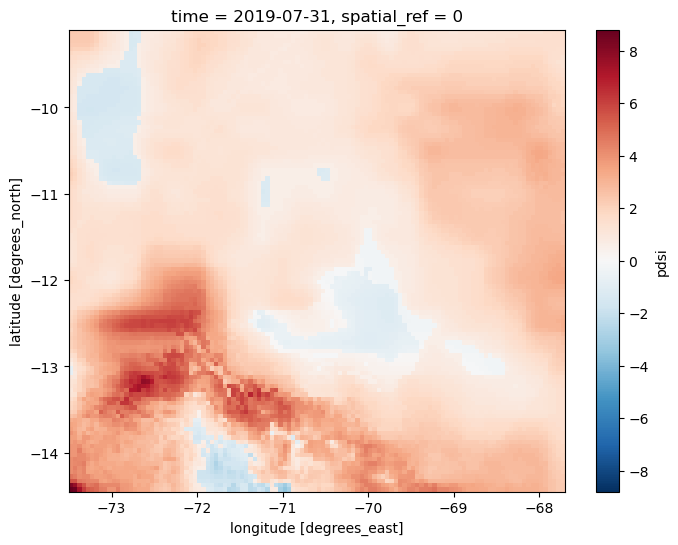

In [17]:
ds_clim_renamed.pdsi.isel(time=210).plot(figsize=(8,6))

In [18]:
# Suppose your dataset is ds_clim_renamed
# Pixel resolution in x (longitude) and y (latitude)
dx = float(ds_clim_renamed['lon'][1] - ds_clim_renamed['lon'][0])
dy = float(ds_clim_renamed['lat'][1] - ds_clim_renamed['lat'][0])

print(f"Pixel size in x (lon): {dx} degrees")
print(f"Pixel size in y (lat): {dy} degrees")

Pixel size in x (lon): 0.0500030517578125 degrees
Pixel size in y (lat): -0.049999237060546875 degrees


In [19]:
# Suppose your dataset is ds_clim_renamed
# Pixel resolution in x (longitude) and y (latitude)
dx = float(lai_xr['lon'][1] - lai_xr['lon'][0])
dy = float(lai_xr['lat'][1] - lai_xr['lat'][0])

print(f"Pixel size in x (lon): {dx} degrees")
print(f"Pixel size in y (lat): {dy} degrees")

Pixel size in x (lon): 0.0500030517578125 degrees
Pixel size in y (lat): -0.049999237060546875 degrees


In [20]:
da = lai_xr['lai']
da.rio  # This will attach rioxarray functionality if not already attached

# Check the CRS
print(da.rio.crs)

EPSG:4326


In [21]:
ds_combined = xr.merge([ds_clim_renamed, lai_xr])

print(ds_combined)

<xarray.Dataset> Size: 181MB
Dimensions:      (time: 228, lon: 116, lat: 107)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB 32.1 32.0 31.9 ... 31.1 31.2 31.1
    tmmn         (time, lat, lon) float64 23MB 22.2 22.2 22.1 ... 22.0 22.1 21.9
    pr           (time, lat, lon) float64 23MB 359.0 361.0 370.0 ... 392.0 399.0
    pdsi         (time, lat, lon) float64 23MB -1.68 -1.65 -1.57 ... -2.09 -2.06
    def          (time, lat, lon) float64 23MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vpd          (time, lat, lon) float64 23MB 0.89 0.88 0.87 ... 0.93 0.94 0.93
    soil         (time, lat, lon) float64 23MB 156.8 156.0 154.5 ... 234.9 229.8
    lai          (time, lat, lon) float64 23MB ...


/tmp/ipykernel_83/1042284820.py:1: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_combined = xr.merge([ds_clim_renamed, ds_lai])


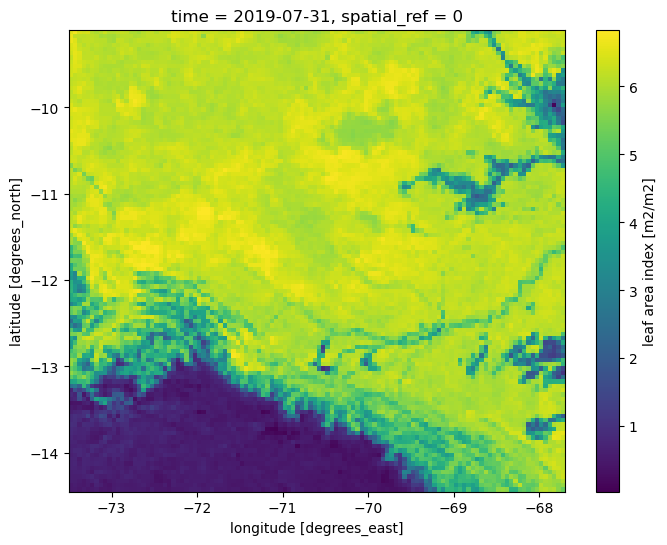

In [22]:
ds_combined.lai.isel(time=210).plot(figsize=(8,6))

In [23]:
lat = float(ds_combined['lat'].mean())  # mean latitude of the dataset

dx_deg = float(ds_combined['lon'][1] - ds_combined['lon'][0])
dy_deg = float(ds_combined['lat'][1] - ds_combined['lat'][0])

dx_m = dx_deg * 111320 * np.cos(np.deg2rad(lat))  # meters per pixel in x
dy_m = dy_deg * 111320                             # meters per pixel in y

print(f"Pixel size in x: {dx_m:.2f} meters")
print(f"Pixel size in y: {dy_m:.2f} meters")

Pixel size in x: 5449.20 meters
Pixel size in y: -5565.92 meters


In [24]:
# Export to a new Zarr directory
output_path = "/home/jovyan/large_files/climLai_merged.nc"
ds_combined.to_netcdf(output_path)

# Run to here - change folder to somewhere in your own filespace

# IGNORE FROM HERE DOWN
#
#
#
#

In [20]:
path = "/home/jovyan/large_files/climLai_merged.nc"
ds_combined = xr.open_dataset(path)

# Set spatial dims and CRS
lai_xr = lai_xr.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
# lai_xr = lai_xr.rio.write_crs("EPSG:4326", inplace=True)  # assuming it's lat/lon WGS84

if ds_combined.rio.crs is None:
    ds_combined = ds_combined.rio.write_crs("EPSG:4326")

print(ds_combined)
# print(lai_xr.time.values)  # check dates
da = ds_combined['lai']
da.rio  # This will attach rioxarray functionality if not already attached



# Check the CRS
print(da.rio.crs)
print(da.dims)
# Print all timestamps_listtamps
print(ds_combined.time.values)

<xarray.Dataset> Size: 181MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB ...
    tmmn         (time, lat, lon) float64 23MB ...
    pr           (time, lat, lon) float64 23MB ...
    pdsi         (time, lat, lon) float64 23MB ...
    def          (time, lat, lon) float64 23MB ...
    vpd          (time, lat, lon) float64 23MB ...
    soil         (time, lat, lon) float64 23MB ...
    lai          (time, lat, lon) float64 23MB ...
EPSG:4326
('time', 'lat', 'lon')
['2002-01-31T00:00:00.000000000' '2002-02-28T00:00:00.000000000'
 '2002-03-31T00:00:00.000000000' '2002-04-30T00:00:00.000000000'
 '2002-05-31T00:00:00.000000000' '2002-06-30T00:00:00.000000000'

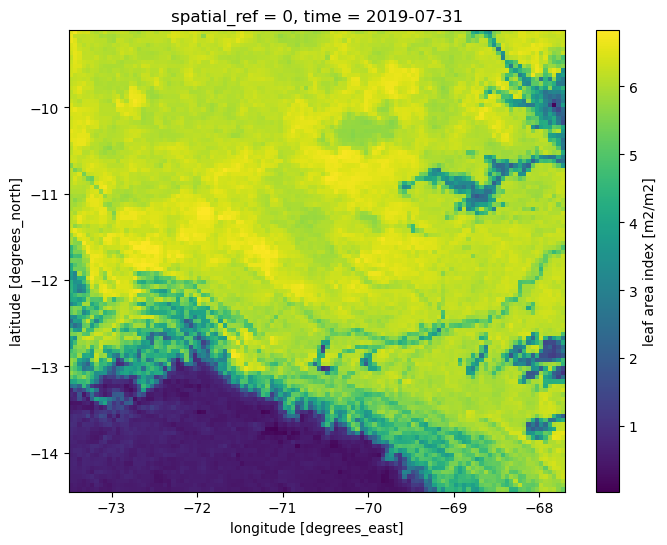

In [21]:
ds_combined.lai.isel(time=210).plot(figsize=(8,6))


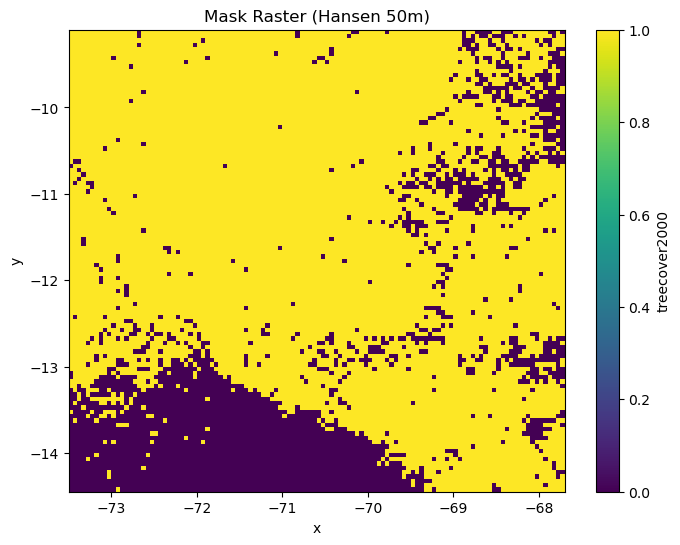

In [22]:
# 1️⃣ Load the mask GeoTIFF
mask_tif = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/hansenMask_mode_50m_v2.tif")

if 'band' in mask_tif.dims and mask_tif.sizes['band'] == 1:
    mask_tif = mask_tif.squeeze('band')

mask_tif.plot(figsize=(8, 6))
plt.title("Mask Raster (Hansen 50m)")
plt.show()


In [23]:
print("ds_combined CRS:", ds_combined.rio.crs)
print("ds_combined transform:", ds_combined.rio.transform())
print("ds_combined pixel size:", ds_combined.rio.resolution())
print("ds_combined shape:", ds_combined.rio.shape)

print("mask CRS:", mask_tif.rio.crs)
print("mask transform:", mask_tif.rio.transform())
print("mask pixel size:", mask_tif.rio.resolution())
print("mask shape:", mask_tif.rio.shape)

print(mask_tif.dims)

ds_combined CRS: EPSG:4326
ds_combined transform: | 0.05, 0.00,-73.50|
| 0.00,-0.05,-9.10|
| 0.00, 0.00, 1.00|
ds_combined pixel size: (0.05, -0.04999999280245799)
ds_combined shape: (107, 116)
mask CRS: EPSG:4326
mask transform: | 0.05, 0.00,-73.50|
| 0.00,-0.05,-9.10|
| 0.00, 0.00, 1.00|
mask pixel size: (0.05, -0.04999999280245799)
mask shape: (107, 116)
('y', 'x')


In [24]:
# 4️⃣ Expand mask to have the same time dimension as ds_combined
mask_data = xr.DataArray(
    np.broadcast_to(mask_tif.values, (ds_combined.dims['time'], *mask_tif.shape)),
    coords={
        "time": ds_combined.time,
        "lat": ds_combined.lat,
        "lon": ds_combined.lon
    },
    dims=("time", "lat", "lon")
)

# 5️⃣ Optionally wrap as Dataset for merging
mask_ds = xr.Dataset({"forestMask": mask_data})

# ✅ Check
print(mask_ds)

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 228, lat: 107, lon: 116)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat         (lat) float32 428B -9.125 -9.175 -9.225 ... -14.33 -14.38 -14.43
  * lon         (lon) float32 464B -73.47 -73.42 -73.38 ... -67.82 -67.78 -67.72
Data variables:
    forestMask  (time, lat, lon) uint8 3MB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1


/tmp/ipykernel_6020/3628050788.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.broadcast_to(mask_tif.values, (ds_combined.dims['time'], *mask_tif.shape)),


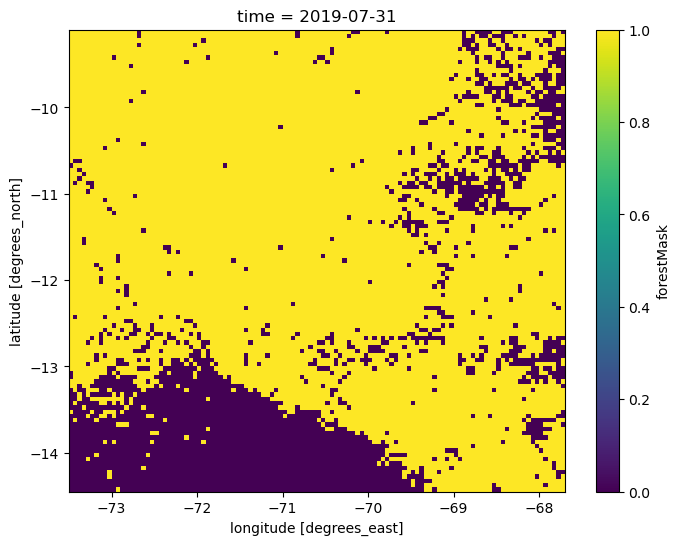

In [25]:
mask_ds.forestMask.isel(time=210).plot(figsize=(8,6))

In [26]:
ds_withMask = xr.merge([ds_combined, mask_ds])

ds_withMask

<xarray.Dataset> Size: 184MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    tmmx         (time, lat, lon) float64 23MB ...
    tmmn         (time, lat, lon) float64 23MB ...
    pr           (time, lat, lon) float64 23MB ...
    pdsi         (time, lat, lon) float64 23MB ...
    def          (time, lat, lon) float64 23MB ...
    vpd          (time, lat, lon) float64 23MB ...
    soil         (time, lat, lon) float64 23MB ...
    lai          (time, lat, lon) float64 23MB ...
    forestMask   (time, lat, lon) uint8 3MB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1

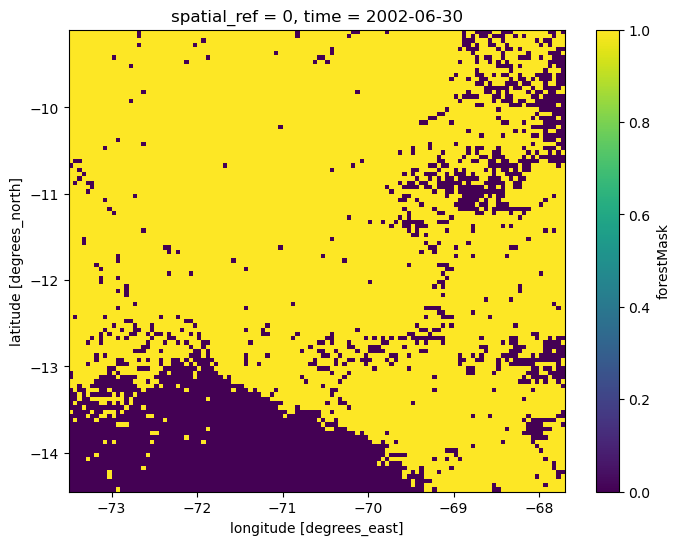

In [27]:
ds_withMask.forestMask.isel(time=5).plot(figsize=(8,6))

In [30]:
mask = ds_withMask["forestMask"] > 0

masked_vars = {}
for var in ds_withMask.data_vars:
    if var != "forestMask":  # skip the mask itself
        masked_vars[var] = ds_withMask[var].where(mask)

ds_masked = xr.Dataset(masked_vars, coords=ds_withMask.coords)

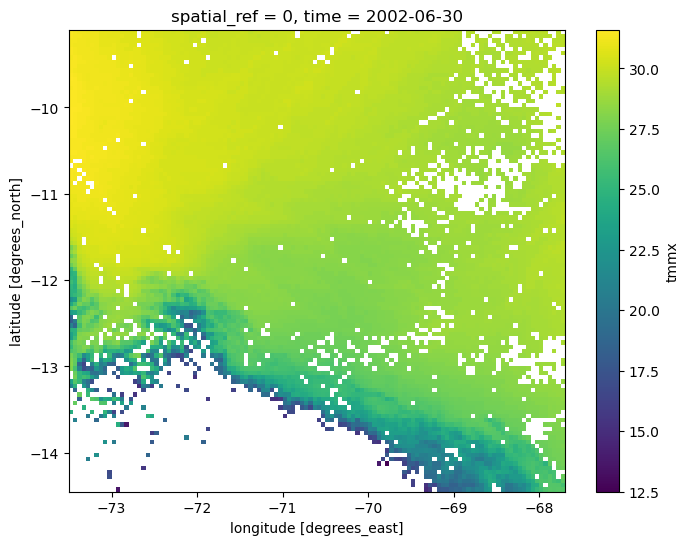

In [31]:
ds_masked.tmmx.isel(time=5).plot(figsize=(8,6))

In [33]:
output_path = "/home/jovyan/large_files/climLai_masked_v2.nc"
ds_masked.to_netcdf(output_path)